In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Libraries and dependencies

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import scipy.spatial
import json
from matplotlib import cm as CM
from image import *
import torch
import torch.nn as nn
import shutil
from torchvision import models
from tqdm import tqdm
from torchvision import datasets, transforms
import sys
sys.path.append('/content/drive/MyDrive/ADIP')
from model import CSRNet
from utils import save_net, load_net
%matplotlib inline

In [6]:
# gaussian filter function: generate density map

def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [7]:
# set the root to the dataset directory

root = '/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/'


In [8]:
# generate paths to image folders in dataset

part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [9]:
# paths for Part A images
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [10]:
# generate the density maps for images in Part A of dataset

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/IMG_11.jpg
(686, 1024)
generate density...
done.
/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/IMG_102.jpg
(768, 1024)
generate density...
done.
/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
/content/drive/MyDrive/ADIP/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/IMG_10.jpg
(683, 1024)
generate density...


KeyboardInterrupt: ignored

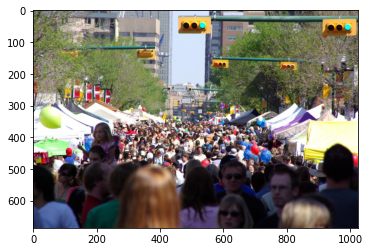

In [20]:
# visualize an image sample from Part A

plt.imshow(Image.open(img_paths[0]))


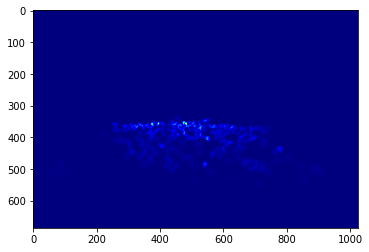

In [ ]:
# density map of sample image

gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [21]:
# ground truth (count estimate) of sample image

np.sum(groundtruth)

233.99999999999994

In [ ]:
# pathsets for Part B of dataset

path_sets = [part_B_train,part_B_test]

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [1]:
# generate the density maps for images in Part B of dataset

for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

NameError: ignored

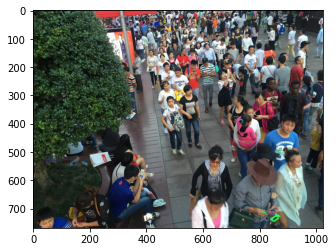

In [ ]:
# visualize an image sample from Part B

plt.imshow(Image.open(img_paths[0]))

In [ ]:
# density map of sample image

gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
# ground truth (count estimate) of sample image
np.sum(groundtruth)

In [2]:
# train model and save weights
# Shanghai A
!python /content/drive/MyDrive/ADIP/train.py /content/drive/MyDrive/ADIP/part_A_train.json /content/drive/MyDrive/ADIP/part_A_val.json 0 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 0, processed 0 samples, lr 0.0000001000
Epoch: [0][0/1200]	Time 0.074 (0.074)	Data 0.016 (0.016)	Loss 1.8520 (1.8520)	
^C


In [2]:
# train model and save weights
# Shanghai B
!python /content/drive/MyDrive/ADIP/train.py /content/drive/MyDrive/ADIP/part_B_train.json /content/drive/MyDrive/ADIP/part_B_val.json 0 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 0, processed 0 samples, lr 0.0000001000
Epoch: [0][0/1600]	Time 0.957 (0.957)	Data 0.774 (0.774)	Loss 3.4791 (3.4791)	
Epoch: [0][30/1600]	Time 1.996 (1.939)	Data 0.802 (0.491)	Loss 1.3352 (14.4728)	
Traceback (most recent call last):
  File "/content/drive/MyDrive/ADIP/train.py", line 230, in <module>
    main()        
  File "/content/drive/MyDrive/ADIP/train.py", line 92, in main
    train(train_list, model, criterion, optimizer, epoch)
  File "/content/drive/MyDrive/ADIP/train.py", line 131, in train
    for i,(img, target)in enumerate(train_loader):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 435, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 475, in _next_d

KeyboardInterrupt: ignored